Match Selection

In [1]:
import os

# Directorio raíz donde se guardan los resultados
INPUT_DIR = "input"
OUTPUT_DIR = "output"

# Buscar carpetas disponibles
partidos_disponibles = [
    p for p in os.listdir(INPUT_DIR)
    if os.path.isdir(os.path.join(INPUT_DIR, p))
]

# Mostrar opciones
print("📁 Partidos disponibles:")
for i, partido in enumerate(partidos_disponibles):
    print(f"  [{i}] {partido}")

# Pedir selección
indice = input("\n🟢 Ingrese el número del partido que desea analizar: ")

try:
    indice = int(indice)
    partido_seleccionado = partidos_disponibles[indice]
    partido_input_path = os.path.join(INPUT_DIR, partido_seleccionado)
    partido_output_path = os.path.join(OUTPUT_DIR, partido_seleccionado)
    print(f"\n✅ Partido seleccionado: {partido_seleccionado}")
except (ValueError, IndexError):
    raise ValueError("❌ Selección inválida. Por favor reinicie y elija un número válido.")


📁 Partidos disponibles:
  [0] example
  [1] partido1

✅ Partido seleccionado: partido1


Homography Estimation

In [2]:
import os
import numpy as np
import cv2
from skimage import transform

# --- CONFIGURACIÓN ---
INPUT_DIR = "input"
OUTPUT_DIR = "output"
DIAGRAM_POINTS = [(170, 50), (288, 50), (288, 188), (170, 188)]
MAX_DISPLAY_HEIGHT = 720

# --- FUNCIONES AUXILIARES ---

def get_user_points(image, window_name="Selecciona 4 puntos", max_height=MAX_DISPLAY_HEIGHT):
    orig_height, orig_width = image.shape[:2]
    scale = min(1.0, max_height / orig_height)
    display_width = int(orig_width * scale)
    display_height = int(orig_height * scale)
    resized_image = cv2.resize(image, (display_width, display_height), interpolation=cv2.INTER_AREA)
    
    points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            real_x = int(x / scale)
            real_y = int(y / scale)
            points.append((real_x, real_y))

            img_copy = resized_image.copy()
            for pt in points:
                disp_x = int(pt[0] * scale)
                disp_y = int(pt[1] * scale)
                cv2.circle(img_copy, (disp_x, disp_y), 5, (0, 255, 0), -1)
            cv2.imshow(window_name, img_copy)

            if len(points) == 4:
                cv2.destroyAllWindows()

    cv2.imshow(window_name, resized_image)
    cv2.setMouseCallback(window_name, click_event)
    cv2.waitKey(0)
    return points

def ordenar_puntos(puntos):
    puntos = np.array(puntos)
    idx_visual_ymin = np.argmax(puntos[:, 1])  # Más abajo
    idx_visual_ymax = np.argmin(puntos[:, 1])  # Más arriba
    lado_derecho = puntos[idx_visual_ymax][0] > puntos[idx_visual_ymin][0]

    idx_xmin = np.argmin(puntos[:, 0])
    idx_xmax = np.argmax(puntos[:, 0])
    idx_ymin = np.argmin(puntos[:, 1])
    idx_ymax = np.argmax(puntos[:, 1])

    if lado_derecho:
        inf_izq = puntos[idx_xmin]
        sup_der = puntos[idx_xmax]
        inf_der = puntos[idx_ymax]
        sup_izq = puntos[idx_ymin]
    else:
        inf_der = puntos[idx_xmax]
        sup_izq = puntos[idx_xmin]
        inf_izq = puntos[idx_ymax]
        sup_der = puntos[idx_ymin]

    return np.array([sup_izq, sup_der, inf_der, inf_izq])

def ensure_output_dirs(base_path):
    for subfolder in ['homography_matrices', 'clips', 'csv', 'analysis']:
        os.makedirs(os.path.join(base_path, subfolder), exist_ok=True)

# --- FLUJO PRINCIPAL ---

print(f"\nProcesando partido: {partido}")
partido_output_path = os.path.join(OUTPUT_DIR, partido)
ensure_output_dirs(partido_output_path)

for clip_name in os.listdir(partido_input_path):
    if not clip_name.endswith(".mp4"):
        continue

    clip_path = os.path.join(partido_input_path, clip_name)
    cap = cv2.VideoCapture(clip_path)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"❌ No se pudo leer: {clip_name}")
        continue

    print(f"\n🎥 Clip: {clip_name}")
    puntos = get_user_points(frame.copy(), f"Selecciona 4 puntos para {clip_name}")
    puntos_ordenados = ordenar_puntos(puntos)

    tform = transform.estimate_transform(
        'projective',
        np.array(puntos_ordenados, dtype=np.float32),
        np.array(DIAGRAM_POINTS, dtype=np.float32)
    )

    homography_matrix = tform.params
    clip_base = os.path.splitext(clip_name)[0]
    matrix_path = os.path.join(partido_output_path, 'homography_matrices', f"{clip_base}.npy")
    np.save(matrix_path, homography_matrix)
    print(f"✅ Homografía guardada en: {matrix_path}")



Procesando partido: partido1

🎥 Clip: ClipLF1.mp4
✅ Homografía guardada en: output\partido1\homography_matrices\ClipLF1.npy

🎥 Clip: ClipLF2.mp4
✅ Homografía guardada en: output\partido1\homography_matrices\ClipLF2.npy

🎥 Clip: ClipS1.mp4
✅ Homografía guardada en: output\partido1\homography_matrices\ClipS1.npy

🎥 Clip: ClipS2.mp4
✅ Homografía guardada en: output\partido1\homography_matrices\ClipS2.npy


Player tracking and shooting detection

In [3]:
from ultralytics import YOLO

# --- Cargar modelos YOLO una vez ---
shoot_detector = YOLO("modules/action_recognition/runs/detect/bsr_v2/weights/best.pt")
object_detector = YOLO("modules/object_detection/runs/detect/bod_v1/weights/best.pt")

def getColor(class_name):
    switch = {
        'player': (255, 0, 0),       # Azul
        'basketball': (0, 165, 255), # Naranja
        'rim': (0, 0, 255),          # Rojo
        'made-shot': (0, 255, 0)     # Verde
    }
    return switch.get(class_name, (0, 0, 0)) 

def drawBBox(frame, x1, y1, x2, y2, label, class_name):
    color = getColor(class_name)
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

def drawPosition(frame, position, position_label):
    cv2.ellipse(frame, (int(position[0]), int(position[1])), (9, 3), 0, 0, 360, (0, 0, 255), -1)
    cv2.putText(frame, position_label, (int(position[0]) - 50, int(position[1]) + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

def transform_point(position, tform):
    point = np.array([position], dtype=np.float32)
    return tform(point)[0]


# Procesar cada clip de video
for clip_name in os.listdir(partido_input_path):
    if not clip_name.endswith(".mp4"):
        continue

    clip_base = os.path.splitext(clip_name)[0]
    clip_path = os.path.join(partido_input_path, clip_name)

    # Cargar homografía asociada
    matrix_path = os.path.join(partido_output_path, 'homography_matrices', f"{clip_base}.npy")
    if not os.path.exists(matrix_path):
        print(f"⚠️ No se encontró homografía para {clip_name}, se omite.")
        continue

    homography_matrix = np.load(matrix_path)
    tform = transform.ProjectiveTransform()
    tform.params = homography_matrix

    # Configurar video
    cap = cv2.VideoCapture(clip_path)
    fourcc = cv2.VideoWriter_fourcc(*"avc1")
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_video_path = os.path.join(partido_output_path, "clips", f"{clip_base}_detected.mp4")
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # CSV de eventos
    csv_lines = []
    rim_logged = False
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        # Detección de tiros
        shoot_results = shoot_detector(frame)
        for result in shoot_results[0].boxes.data.tolist():
            x1, y1, x2, y2, conf, cls = result
            cls = int(cls)

            if shoot_detector.names[cls] == 'shoot' and conf > 0.3:

                drawBBox(frame, x1, y1, x2, y2, f"shoot {conf:.2f}", 'shoot')

                position = (int((x1 + x2) / 2), int(y2))
                drawPosition(frame, position, f"x:{position[0]} y:{position[1]}")

                # Proyectar punto a la vista del diagrama
                transformed_position = transform_point(position, tform)

                # Guardar ocurrencia de tiro con el fotograma actual y la posición proyectada
                csv_lines.append(f"s,{frame_idx},{int(transformed_position[0])},{int(transformed_position[1])}")

        # Detección de objetos
        object_results = object_detector(frame)
        for result in object_results[0].boxes.data.tolist():
            x1, y1, x2, y2, conf, cls = result
            cls = int(cls)
            label_name = object_detector.names[cls]

            if (label_name in ['player', 'rim'] and conf > 0.7) or \
                (label_name == 'basketball' and conf > 0.5):

                drawBBox(frame, x1, y1, x2, y2, f"{label_name} {conf:.2f}", label_name)

                # Anotar la posición original del aro en el primer fotograma
                if label_name == 'rim' and not rim_logged:
                    x_rim = int((x1 + x2) / 2)
                    y_rim = int((y1 + y2) / 2)
                    csv_lines.insert(0, f"r,0,{x_rim},{y_rim}")
                    rim_logged = True

            elif label_name == 'made-shot' and conf > 0.3:
                position = (int((x1 + x2) / 2), int((y1 + y2) / 2))
                drawBBox(frame, x1, y1, x2, y2, f"{label_name} {conf:.2f}", label_name)

                # Guardar ocurrencia de tiro encestado con el fotograma actual y la posición original
                csv_lines.append(f"m,{frame_idx},{position[0]},{position[1]}")

        # Guardar frame procesado
        out.write(frame)

    # Guardar CSV
    csv_path = os.path.join(partido_output_path, "csv", f"{clip_base}_events.csv")
    with open(csv_path, "w") as f:
        for line in csv_lines:
            f.write(line + "\n")

    # Liberar recursos
    cap.release()
    out.release()
    print(f"✅ Clip procesado y guardado: {output_video_path}")
    print(f"📝 CSV generado: {csv_path}")


0: 576x1024 (no detections), 80.2ms
Speed: 8.2ms preprocess, 80.2ms inference, 53.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 players, 1 rim, 52.6ms
Speed: 4.1ms preprocess, 52.6ms inference, 117.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 (no detections), 27.0ms
Speed: 5.6ms preprocess, 27.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 players, 1 rim, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 (no detections), 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 players, 1 rim, 16.6ms
Speed: 5.2ms preprocess, 16.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 (no detections), 24.9ms
Speed: 5.2ms preprocess, 24.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 players, 1 rim, 13.0ms
Speed: 

Shoot Analysis

✅ Zonas cargadas desde archivo pickle:
  - Zona 1 - Triple frontal
  - Zona 2 - Triple ala dcha
  - Zona 3 - Triple ala izq
  - Zona 4 - Triple esquina dcha
  - Zona 5 - Triple esquina izq
  - Zona 6 - Dos frontal
  - Zona 7 - Dos ala dcha
  - Zona 8 - Dos ala izq
  - Zona 9 - Dos esquina dcha
  - Zona 10 - Dos esquina izq
  - Zona 11 - Zona 3 segs

📂 Procesando CSVs del partido: partido1


,Zona,Aciertos,Intentos,Efectividad (%)
0,Zona 1 - Triple frontal,0,1,0.0
1,Zona 2 - Triple ala dcha,1,1,100.0
2,Zona 3 - Triple ala izq,0,0,0.0
3,Zona 4 - Triple esquina dcha,0,0,0.0
4,Zona 5 - Triple esquina izq,0,0,0.0
5,Zona 6 - Dos frontal,0,0,0.0
6,Zona 7 - Dos ala dcha,0,0,0.0
7,Zona 8 - Dos ala izq,0,0,0.0
8,Zona 9 - Dos esquina dcha,0,0,0.0
9,Zona 10 - Dos esquina izq,0,0,0.0


📄 Archivo CSV guardado en: output\partido1\analysis\shot_stats.csv
🖼️ Mapa de tiros individuales guardado en: output\partido1\analysis\shot_chart.png
🖼️ Heatmap guardado en: output\partido1\analysis\shot_heatmap.png


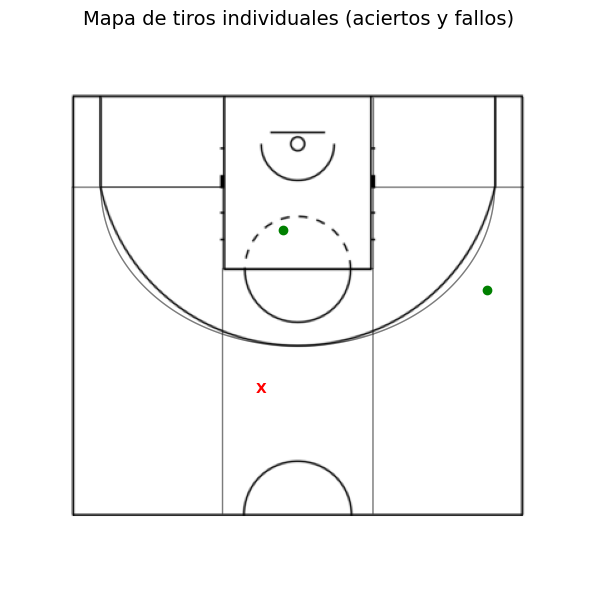

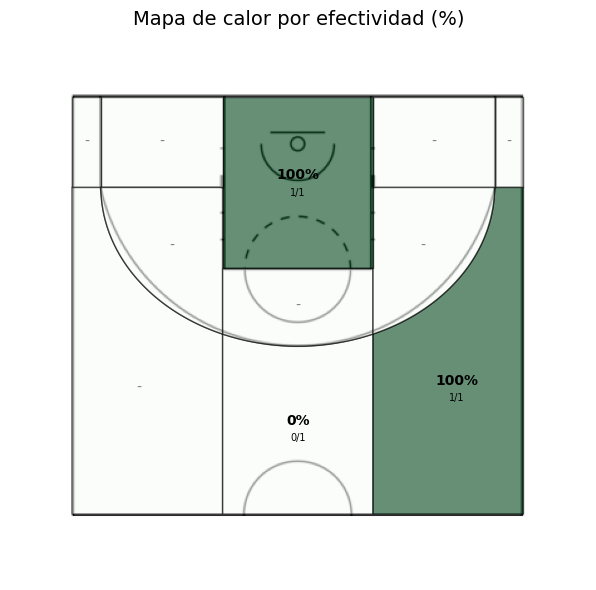

In [4]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import re


img_path = "assets/court_diagrams/fiba_white_court_half.png"
court_img = cv2.imread(img_path)
court_img = cv2.cvtColor(court_img, cv2.COLOR_BGR2RGB)

# -------------------------------
# CARGAR ZONAS DESDE PICKLE
# -------------------------------
with open("modules/data_analysis/court_zones.pkl", "rb") as f:
    zonas_estudio = pickle.load(f)

print("✅ Zonas cargadas desde archivo pickle:")
for nombre in zonas_estudio:
    print("  -", nombre)

# -------------------------------
# RECORRER TODOS LOS PARTIDOS EN OUTPUT_DIR
# -------------------------------

zonas_detectadas_global = []

def asignar_zona(point, zonas_dict):
    for nombre, poly in zonas_dict.items():
        if poly.contains(point):
            return nombre
    return None


csv_folder = os.path.join(partido_output_path, "csv")

print(f"\n📂 Procesando CSVs del partido: {partido}")
csv_files = sorted(glob(os.path.join(csv_folder, "*.csv")))

for csv_path in csv_files:
    df = pd.read_csv(csv_path, header=None, names=['tipo', 'frame', 'x', 'y'])

    rim_row = df[df['tipo'] == 'r']
    if rim_row.empty:
        continue
    rim_pos = (rim_row.iloc[0]['x'], rim_row.iloc[0]['y'])

    shots = df[df['tipo'] == 's'][['frame', 'x', 'y']]
    mades = df[df['tipo'] == 'm'][['frame', 'x', 'y']]

    clusters = []
    current_cluster = []
    last_frame = -10

    for _, row in shots.iterrows():
        if row['frame'] - last_frame > 3 and current_cluster:
            clusters.append(current_cluster)
            current_cluster = []
        current_cluster.append((int(row['frame']), row['x'], row['y']))
        last_frame = row['frame']

    if current_cluster:
        clusters.append(current_cluster)

    main_cluster = max(clusters, key=lambda c: len(c)) if clusters else []
    cleaned_shots = []

    if main_cluster:
        cluster = np.array(main_cluster)
        avg_frame = int(np.mean(cluster[:, 0]))
        avg_x = np.mean(cluster[:, 1])
        avg_y = np.mean(cluster[:, 2])
        cleaned_shots.append(('s', avg_frame, avg_x, avg_y))

    if not mades.empty:
        made_array = mades[['frame', 'x', 'y']].values
        center_idx = len(made_array) // 2
        cleaned_shots.append(('m', int(made_array[center_idx][0]),
                                made_array[center_idx][1],
                                made_array[center_idx][2]))

    has_made = any(tipo == 'm' for tipo, *_ in cleaned_shots)
    for tipo, frame, x, y in cleaned_shots:
        if tipo == 's':
            punto = Point(x, y)
            zona = asignar_zona(punto, zonas_estudio)
            if zona:
                zonas_detectadas_global.append((zona, has_made, x, y))

# -------------------------------
# PREPARAR DIRECTORIO DE ANÁLISIS
# -------------------------------

# Asegurarse de que haya al menos un partido válido para usar su ruta
if 'partido_output_path' in locals():
    analysis_path = os.path.join(partido_output_path, "analysis")
    os.makedirs(analysis_path, exist_ok=True)

    stats_csv_path = os.path.join(analysis_path, "shot_stats.csv")
    heatmap_img_path = os.path.join(analysis_path, "shot_heatmap.png")
    shot_chart_img_path = os.path.join(analysis_path, "shot_chart.png")


# -------------------------------
# TABLA DE EFECTIVIDAD
# -------------------------------

def numero_zona(zona):
    match = re.search(r'Zona (\d+)', zona)
    return int(match.group(1)) if match else float('inf')

conteo = defaultdict(lambda: {'aciertos': 0, 'intentos': 0})

for zona, acierto, _, _ in zonas_detectadas_global:
    conteo[zona]['intentos'] += 1
    if acierto:
        conteo[zona]['aciertos'] += 1

df_stats = pd.DataFrame([
    {
        'Zona': zona,
        'Aciertos': datos['aciertos'],
        'Intentos': datos['intentos'],
        'Efectividad (%)': 100 * datos['aciertos'] / datos['intentos'] if datos['intentos'] > 0 else 0
    }
    for zona, datos in conteo.items()
])

for nombre in zonas_estudio.keys():
    if nombre not in df_stats['Zona'].values:
        df_stats = pd.concat([df_stats, pd.DataFrame([{
            'Zona': nombre,
            'Aciertos': 0,
            'Intentos': 0,
            'Efectividad (%)': 0.0
        }])], ignore_index=True)

df_stats = df_stats.sort_values(by='Zona', key=lambda x: x.map(numero_zona)).reset_index(drop=True)

# Mostrar tabla
display(df_stats)
df_stats.to_csv(stats_csv_path, index=False)
print(f"📄 Archivo CSV guardado en: {stats_csv_path}")

# -------------------------------
# DIAGRAMA DE TIROS INDIVIDUALES
# -------------------------------
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.imshow(court_img)

for nombre, zona in zonas_estudio.items():
    if isinstance(zona, Polygon):
        coords = np.array(zona.exterior.coords)
        patch = patches.Polygon(coords, facecolor='none', edgecolor='black', alpha=0.3)
        ax.add_patch(patch)
    elif isinstance(zona, MultiPolygon):
        largest_poly = max(zona.geoms, key=lambda g: g.area)
        coords = np.array(largest_poly.exterior.coords)
        patch = patches.Polygon(coords, facecolor='none', edgecolor='black', alpha=0.3)
        ax.add_patch(patch)

for _, acierto, x, y in zonas_detectadas_global:
    if acierto:
        ax.plot(x, y, 'o', color='green', markersize=6)
    else:
        ax.text(x, y, 'X', color='red', fontsize=10,
                ha='center', va='center', weight='bold')

plt.title("Mapa de tiros individuales (aciertos y fallos)", fontsize=14)
plt.axis('off')
plt.tight_layout()

plt.savefig(shot_chart_img_path, dpi=300)
print(f"🖼️ Mapa de tiros individuales guardado en: {shot_chart_img_path}")

# -------------------------------
# HEATMAP DE EFECTIVIDAD
# -------------------------------

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.imshow(court_img)

max_efectividad = df_stats['Efectividad (%)'].max()

for nombre, zona in zonas_estudio.items():
    efectividad = df_stats.loc[df_stats['Zona'] == nombre, 'Efectividad (%)'].values[0]
    intentos = df_stats.loc[df_stats['Zona'] == nombre, 'Intentos'].values[0]
    aciertos = df_stats.loc[df_stats['Zona'] == nombre, 'Aciertos'].values[0]

    intensidad = efectividad / max_efectividad if max_efectividad > 0 else 0
    color = plt.cm.Greens(intensidad)

    if isinstance(zona, Polygon):
        coords = np.array(zona.exterior.coords)
        patch = patches.Polygon(coords, facecolor=color, edgecolor='black', alpha=0.6)
        ax.add_patch(patch)
        centroid = zona.centroid
        cx, cy = centroid.x, centroid.y
    elif isinstance(zona, MultiPolygon):
        largest_poly = max(zona.geoms, key=lambda g: g.area)
        coords = np.array(largest_poly.exterior.coords)
        patch = patches.Polygon(coords, facecolor=color, edgecolor='black', alpha=0.6)
        ax.add_patch(patch)
        centroid = largest_poly.centroid
        cx, cy = centroid.x, centroid.y

    if intentos > 0:
        # Añadir texto con porcentaje y fracción
        ax.text(cx, cy - 6, f'{efectividad:.0f}%', color='black',
                fontsize=10, ha='center', va='center', weight='bold')
        ax.text(cx, cy + 8, f'{aciertos}/{intentos}', color='black',
                fontsize=7, ha='center', va='center')
    else:
        ax.text(cx, cy, '-', color='gray', fontsize=10, ha='center', va='center', style='italic')

plt.title('Mapa de calor por efectividad (%)', fontsize=14)
plt.axis('off')
plt.tight_layout()

plt.savefig(heatmap_img_path, dpi=300)
print(f"🖼️ Heatmap guardado en: {heatmap_img_path}")